In [1]:
import numpy as np
import math
from scipy.spatial import distance
from warnings import warn
import time
from tqdm.auto import tqdm
from pathlib import Path

In [2]:
from cpp_algorithms.testers import imshow, imshow_scatter
from cpp_algorithms.testers import get_all_area_maps, get_random_coords, get_area_map
from cpp_algorithms.testers.metrics import coverage_metrics
from cpp_algorithms.testers.display_funcs import printer
from cpp_algorithms.testers import is_valid, adjacency_test

# A - Star, Backtracking
(untouched)

In [3]:
"""
Old backtracking list function
"""
def backtracking_list(Memory, diameter, M, Critical_x, Critical_y):
    resultList=[]
    backup=[]
    flag=0
    
    for a in Memory:
        x=a[0]
        y=a[1]
        sum1=0
        
        if(sum(map(sum, M[x:x-diameter:-1, y+diameter:y+2*diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter]))<255*diameter*diameter   or sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
        
        if(sum(map(sum, M[x:x-diameter:-1, y+diameter:y+2*diameter])) == 255*diameter*diameter and (sum(map(sum, M[x-diameter:x-2*diameter:-1, y+diameter:y+2*diameter])) <255*diameter*diameter or sum(map(sum, M[x-diameter:x-2*diameter:-1, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x:x-diameter:-1, y-diameter:y])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) <255*diameter*diameter  or sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
            
        if(sum(map(sum, M[x:x-diameter:-1, y-diameter:y])) == 255*diameter*diameter and (sum(map(sum, M[x-diameter:x-2*diameter:-1, y:y-diameter:-1]))<255*diameter*diameter or sum(map(sum, M[x-diameter:x-2*diameter:-1, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x+diameter:x:-1, y:y+diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) <255*diameter*diameter or sum(map(sum, M[x:x+diameter, y:y-diameter:-1])) == 150*diameter*diameter)):
            sum1=sum1+1
            
        if(sum(map(sum, M[x+diameter:x:-1, y:y+diameter])) == 255*diameter*diameter and (sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) <255*diameter*diameter or sum(map(sum, M[x:x+diameter, y+diameter:y+2*diameter])) == 150*diameter*diameter)):
            sum1=sum1+1
        
        if(sum1==0 and (sum(map(sum, M[x-diameter: x-2*diameter:-1, y:y+diameter])) ==255*diameter*diameter or sum(map(sum, M[x+diameter: x:-1, y:y+diameter])) == 255*diameter*diameter or sum(map(sum, M[x: x-diameter:-1, y+diameter: y+2*diameter]))==255*diameter*diameter or sum(map(sum, M[x: x-diameter:-1, y-diameter: y])) ==255*diameter*diameter)):
            backup.append(a)
            
        if sum1 >= 1:
            resultList.append(a)
            
            
    if (len(resultList) ==0 and len(backup)==0):
        return 0, 0
    
    if(len(resultList)!=0):
        if(len(resultList)==1):
            for i in resultList:
                x=i[0]
                y=i[1]
                #print(x, y)
                return x, y
             
        else:
            minimum=[]
            for z in resultList:
                p1=(Critical_x, Critical_y)
                p2=(z[0], z[1])
                d=distance.euclidean(p1, p2)
                minimum.append(d)
                #print(minimum)
                
    else:
        flag=1
        if(len(backup)==1):
            for i in backup:
                x=i[0]
                y=i[1]
                return x,y
        else:
            minimum=[]
            for z in backup:
                p1=(Critical_x, Critical_y)
                p2=(z[0], z[1])
                d=distance.euclidean(p1, p2)
                minimum.append(d)
            
        
            
    min1=minimum[0]
    index=0
        
    for p in range(len(minimum)):
        if minimum[p] < min1:
            index=p
            min1=minimum[p]
    
    list_of_coord=[] 
    if(flag==1):
        list_of_coord=backup[index]
    else:
        list_of_coord=resultList[index]
    
    return list_of_coord[0], list_of_coord[1]

In [4]:
def heuristic(start, goal):
    #Use Chebyshev distance heuristic if we can move one square either
    #adjacent or diagonal
    D = 1
    D2 = 1
    dx = abs(start[0] - goal[0])
    dy = abs(start[1] - goal[1])
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)
    
def get_vertex_neighbours(pos, diameter, width, height):
    n = []
    #Moves allow link a chess king
    for dx, dy in [(diameter,0),(-diameter,0),(0,diameter),(0,-diameter)]:
        x2 = pos[0] + dx
        y2 = pos[1] + dy
        if x2 < 0 or x2 > width-1  or y2 < 0 or y2 > height-1:
            continue
        n.append((x2, y2))
    return n
    

In [5]:
def AStarSearch(start, end, graph, diameter, width, height):
 
    G = {} #Actual movement cost to each position from the start position
    F = {} #Estimated movement cost of start to end going via this position
 
    #Initialize starting values
    G[start] = 0 
    F[start] = heuristic(start, end)
 
    closedVertices = set()
    openVertices = set([start])
    cameFrom = {}
    
    # Adding a stop condition
    outer_iterations = 0
    max_iterations = (len(graph[0]) * len(graph) // 2)
 
    while len(openVertices) > 0:
        outer_iterations += 1

        if outer_iterations > max_iterations:
            warn("number of iterations has exceeded max iterations")
            
        #Get the vertex in the open list with the lowest F score
        current = None
        currentFscore = None
        for pos in openVertices:
            if current is None or F[pos] < currentFscore:
                currentFscore = F[pos]
                current = pos
 
        #Check if we have reached the goal
        if current == end:
            #Retrace our route backward
            path = [current]
            while current in cameFrom:
                current = cameFrom[current]
                path.append(current)
            path.reverse()
            return path  #Done!
 
        #Mark the current vertex as closed
        openVertices.remove(current)
        closedVertices.add(current)
 
        #Update scores for vertices near the current position
        for neighbour in get_vertex_neighbours(current, diameter, width, height):
            if neighbour in closedVertices: 
                continue #We have already processed this node exhaustively
            x=neighbour[0]
            y=neighbour[1]
            if graph[x][y]!=150:
                continue
            else:
                candidateG = G[current] + 1
 
            if neighbour not in openVertices:
                openVertices.add(neighbour) #Discovered a new vertex
            
            elif candidateG >= G[neighbour]:
                continue #This G score is worse than previously found
 
            #Adopt this G score
            cameFrom[neighbour] = current
            G[neighbour] = candidateG
            H = heuristic(neighbour, end)
            F[neighbour] = G[neighbour] + H
 
    raise RuntimeError("A* failed to find a solution")

In [6]:
def AstarPath(M, Memory, path):
    for q in path:
        x=q[0]
        y=q[1]
        Memory.append((x, y))

# Boustrophedon and caller

In [7]:
def is_valid_vectorized(coords, matrix):
    # Bound check
    assert coords.shape[1] == 2
    h,w = matrix.shape
    x,y = coords.T
    is_within_bounds = (x >= 0) & (x < h) & (y >= 0) & (y < w)
    x = np.clip(x.copy(), 0, h-1)
    y = np.clip(y.copy(), 0, w-1)
    is_not_on_obstacle = (matrix[x,y] != 0) &  (matrix[x,y] != 150)
    return is_within_bounds & is_not_on_obstacle

def backtracking_list(memory, _, matrix, x, y):
    bt_cond_points = {
        "r":  lambda p: p + np.array([[0,1]]), # right
        "tr": lambda p: p + np.array([[-1,1]]), # top-right
        "t":  lambda p: p + np.array([[-1,0]]), # top
        "tl": lambda p: p + np.array([[-1,-1]]), # top-left
        "l":  lambda p: p + np.array([[0,-1]]), # left
        "bl": lambda p: p + np.array([[1,-1]]), # bottom-left
        "b":  lambda p: p + np.array([[1,0]]), # bottom
        "br": lambda p: p + np.array([[1,1]]), # bottom-right
    }
    memory_ = np.array(memory)
    assert memory_.shape[1] == 2, "you've messed up something"
    
    eight_di = {k: bt_cond_points[k](memory_) for k in bt_cond_points}
    is_valid_eight = {k: is_valid_vectorized(eight_di[k], matrix) for k in eight_di}
    cond_a = np.int0(is_valid_eight["r"] & ~is_valid_eight["br"])
    cond_b = np.int0(is_valid_eight["r"] & ~is_valid_eight["tr"])
    cond_c = np.int0(is_valid_eight["l"] & ~is_valid_eight["bl"])
    cond_d = np.int0(is_valid_eight["l"] & ~is_valid_eight["tl"])
    cond_e = np.int0(is_valid_eight["b"] & ~is_valid_eight["bl"])
    cond_f = np.int0(is_valid_eight["b"] & ~is_valid_eight["br"])
    μ_of_s = (cond_a + cond_b+ cond_c + cond_d + cond_e + cond_f)
     
    backtrack_points =  memory_[μ_of_s > 0]
    if backtrack_points.shape[0] == 0:
        return (0,0), True
    else:
        closest_point_idx = ((backtrack_points - np.array([x,y]))**2).sum(axis = 1).argmin()
        return tuple(backtrack_points[closest_point_idx]), False

In [79]:
%timeit -n 10 -r 5 bt_point = backtracking_list(coverage_path, None,area_map, 0,0)

1.72 ms ± 388 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [9]:
def backtracking_list(memory, _, matrix, x, y):
    # Non vectorised implementation, runs faster; contig array alloc takes time!?
    bt_cond_points = {
        "r":  lambda x, y: (x + (+0), y + (+1)), # right
        "tr": lambda x, y: (x + (-1), y + (+1)), # top-right
        "t":  lambda x, y: (x + (-1), y + (+0)), # top
        "tl": lambda x, y: (x + (-1), y + (-1)), # top-left
        "l":  lambda x, y: (x + (+0), y + (-1)), # left
        "bl": lambda x, y: (x + (+1), y + (-1)), # bottom-left
        "b":  lambda x, y: (x + (+1), y + (+0)), # bottom
        "br": lambda x, y: (x + (+1), y + (+1))  # bottom-right
    }
    
    μ_of_s = []; 
    for point in memory:
        av = { k:is_valid(bt_cond_points[k](*point), matrix, [0,150]) for k in bt_cond_points }
        μ_of_s.append(int(av["r"] and  not av["br"]) + int(av["r"] and  not av["tr"]) + 
                      int(av["l"] and  not av["bl"]) + int(av["l"] and  not av["tl"]) + 
                      int(av["b"] and  not av["bl"]) + int(av["b"] and  not av["br"]))
    μ_of_s = np.array(μ_of_s); # backup = np.array(backup);
    memory_ = np.array(memory)
    
    backtrack_points =  memory_[μ_of_s > 0]
    if backtrack_points.shape[0] == 0:
        return (0,0), True
    else:
        closest_point_idx = ((backtrack_points - np.array([x,y]))**2).sum(axis = 1).argmin()
        return tuple(backtrack_points[closest_point_idx]), False

In [107]:
%timeit -n 10 -r 5 _ = backtracking_list(coverage_path, None,area_map, 0,0)

77.5 ms ± 3.05 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [10]:
def visit(matrix, x, y, memory):
    matrix[(x,y)] = 150 # 150 == visited
    memory.append((x, y))
    return x,y

def boustrophedon(matrix, diameter, x, y, memory):
    # TODO :: Variable diameter support
    udlr = {
        "u": lambda x,y : (x-diameter,y),
        "d": lambda x,y : (x+diameter,y),
        "l": lambda x,y : (x,y-diameter),
        "r": lambda x,y : (x,y+diameter)
    }
    u = "u";d = "d";r = "r";l = "l"
    visit(matrix, x, y, memory)
    
    while True:
        dir_ = [u,d,r,l]
        while len(dir_) > 0:
            d_ = dir_.pop(0)
            x_, y_ = udlr[d_](x,y)
            if is_valid((x_,y_), matrix, [0, 150]):
                x, y = visit(matrix, x_, y_, memory)
                break
            elif d_ == l:
                return x, y

In [14]:
def bous_preprocess(area_map):
    """
    Returns matrix that in the form
    that is read by the main algorithm.
    """
    matrix = np.full(area_map.shape, 0, dtype=np.uint8)
    matrix[area_map == 0] = 255
    return matrix

def do_everything(matrix, start_point, break_after_bous=False, timeit=True):
    t = lambda :timeit and time.time()
    times = {
        "bous": [],
        "btrack":[],
        "astar":[]
    }
    store_time = lambda name,value: timeit and times[name].append(value)
    start_time = t()
    
    width, height = matrix.shape
    radius=0.5
    diameter=int(2*radius)

    x, y = start_point
    memory=[]
    
    backtrack_counts = 0
    point_find_failed = 0 

    while True:
        sw = t()
        critical_x, critical_y = boustrophedon(matrix, diameter, x, y, memory)
        store_time("bous", t() - sw)
        
        
        if break_after_bous:
            print("break point",critical_x,critical_y)
            break
            
#         print("bt time")
        sw = t()
        next_, is_end = backtracking_list(memory, diameter, matrix, critical_x, critical_y)
        x,y = next_
        store_time("btrack", t() - sw)
        if is_end:
            break
        else:
            start = (critical_x,critical_y )
            end = (x, y)
            sw = t()
            path = AStarSearch(start, end, matrix, diameter, width, height)
            AstarPath(matrix, memory, path)
            store_time("astar", t() - sw)
            
    times_avg = timeit and {k+"_avg":np.array(times[k]).mean() for k in times}
    times_tot = timeit and {k+"_tot":np.array(times[k]).sum() for k in times}
    times = timeit and {**times_avg, **times_tot}
    end_time = timeit and (time.time() - start_time)
    if timeit: times['total'] = end_time
    timeit and printer(times)
    return memory 

In [12]:
area_maps = get_all_area_maps("./test_maps/")

times ↓
            bous_avg : 0.0007131099700927734
          btrack_avg : 0.001026153564453125
           astar_avg : nan
            bous_tot : 0.0007131099700927734
          btrack_tot : 0.001026153564453125
           astar_tot : 0.0
               total : 0.0020868778228759766

metrics ↓
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 20
   coverage_path_len : 20
            coverage : 0.025906735751295335
          redundancy : 0.0
          area_shape : (32, 32)



/Users/alan/opt/anaconda3/envs/data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.


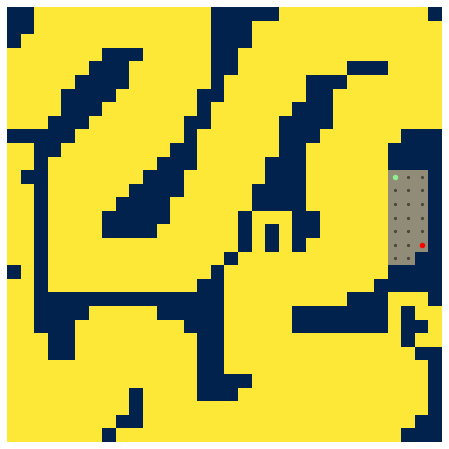

In [17]:
area_map = area_maps[8]

start_point = (12, 28)
matrix = bous_preprocess(area_map)
print("times ↓")
coverage_path = do_everything(matrix, start_point, break_after_bous=False)
end_point = coverage_path[-1]

print("\nmetrics ↓")
printer(coverage_metrics(area_map, coverage_path))
print()

imshow(matrix, figsize=(8, 8), cmap="cividis")                       #Shift + Tab
imshow_scatter(coverage_path, alpha=0.4, color="black",s=5)
imshow_scatter([start_point],color="lightgreen")
imshow_scatter([end_point],color="red")

In [90]:
def cover_test(first_n_area_maps, times):
    t_ = []
    for j,area_map in tqdm(enumerate(area_maps[:first_n_area_maps]),total=first_n_area_maps):
        t = []
        for i in range(times):
            start_point = get_random_coords(area_map, 1)[0]
            matrix = bous_preprocess(area_map)
            try:
                s = time.time()
                coverage_path = do_everything(matrix, start_point, timeit=False)
                t.append(time.time() - s)
            except:
                print(f"j: {j}, start: {start_point} FAILED")
                imshow(area_map)
                return
            end_point = coverage_path[-1]
            metrics = coverage_metrics(area_map, coverage_path)
            if metrics["coverage"] < 1.0:
                print(f"j: {j}, start: {start_point}, end: {end_point}, cover:{metrics['coverage']} ,redun:{metrics['redundancy']}")
                print()
        t_.append(np.array(t).mean())
    return t_

In [91]:
# If returns time without any print then SUCCESS!
cover_test(11,10) # cover test for all the maps <= 50, 50

/Users/alan/opt/anaconda3/envs/data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: number of iterations has exceeded max iterations


j: 8, start: (12, 28), end: (17, 30), cover:0.025906735751295335 ,redun:0.0




[0.03179330825805664,
 0.022915577888488768,
 0.028238415718078613,
 0.04246551990509033,
 0.024263644218444826,
 0.03200762271881104,
 0.026227903366088868,
 0.08608648777008057,
 0.06126809120178223,
 0.06248509883880615,
 0.09094016551971436]

In [553]:
display = False
for i,path in tqdm(enumerate(Path("./test_maps/").iterdir()),total=21):
    if path.suffix != ".png":
        continue
    area_map = get_area_map(path)
    # Remove conditional to run on all maps.
#     if area_map.shape[1] > 50:
#         continue
    print(f"# {i} :: ",area_map.shape, path.name)
    start_point = get_random_coords(area_map, 1)[0]
    matrix = bous_preprocess(area_map)
    coverage_path = do_everything(matrix, start_point)
    end_point = coverage_path[-1]
    printer(coverage_metrics(area_map, coverage_path))
    print(f"adjacency test pass : {adjacency_test(coverage_path)}")
    print()

    if display:
        imshow(matrix, cmap="Greys_r",figsize=(10,10))
        imshow_scatter(coverage_path, alpha=0.5, color="lightblue",s=4)
        imshow_scatter([start_point], color="black")
        imshow_scatter([end_point],color="red")

# 0 ::  (32, 32) corners_0.png
            bous_avg : 0.0006550864169472142
          btrack_avg : 0.027687875848067433
           astar_avg : 0.0002460877100626628
            bous_tot : 0.01244664192199707
          btrack_tot : 0.5260696411132812
           astar_tot : 0.00442957878112793
               total : 0.5431210994720459
     points_to_visit : 716
     obstacle_points : 308
      points_visited : 716
   coverage_path_len : 806
            coverage : 1.0
          redundancy : 0.12569832402234637
          area_shape : (32, 32)
adjacency test pass : True

# 2 ::  (256, 256) comb_9.png
            bous_avg : 0.0011901212831070482
          btrack_avg : 1.3173962680477338
           astar_avg : 0.0034853007342364336
            bous_tot : 0.44153499603271484
          btrack_tot : 488.75401544570923
           astar_tot : 1.2895612716674805
               total : 490.4877858161926
     points_to_visit : 33385
     obstacle_points : 32151
      points_visited : 33385
   coverag

/Users/alan/opt/anaconda3/envs/data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: number of iterations has exceeded max iterations


            bous_avg : 0.001707020038511695
          btrack_avg : 0.9967232890245391
           astar_avg : 0.009699706937752519
            bous_tot : 0.34993910789489746
          btrack_tot : 204.32827425003052
           astar_tot : 1.9787402153015137
               total : 206.658282995224
     points_to_visit : 25866
     obstacle_points : 10998
      points_visited : 25866
   coverage_path_len : 28288
            coverage : 1.0
          redundancy : 0.09363643392870946
          area_shape : (144, 256)
adjacency test pass : True

# 15 ::  (50, 144) comb_3.png
            bous_avg : 0.00047543616521926154
          btrack_avg : 0.14622059776669458
           astar_avg : 0.0004228101326869084
            bous_tot : 0.04992079734802246
          btrack_tot : 15.35316276550293
           astar_tot : 0.04397225379943848
               total : 15.447703838348389
     points_to_visit : 3680
     obstacle_points : 3520
      points_visited : 3680
   coverage_path_len : 4487
          